In [2]:
import sys
import os
import subprocess

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib

from utility_funtions import str2bool_argparse

mpl.rcParams['figure.dpi'] = 80

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

Welcome to JupyROOT 6.10/00


In [3]:
# def vis_events_list(events, column_labels, save_fig_dir=None, base_file_name='vis', events_per_figure=50, max_figures=10, 
#                     vis_gtux=True, vis_gtuy=True, numeric_columns=False, additional_printed_columns=[], subplot_cols=9, close_after_vis=True, show=False,
#                     line_columns_x_y=None, line_columns_gtu_x=None, line_columns_gtu_y=None, line_colors=None, line_alpha=None):

# def vis_events_df(events, save_fig_dir=None, base_file_name='vis', events_per_figure=50, max_figures=10, 
#                   vis_gtux=True, vis_gtuy=True, additional_printed_columns=[], close_after_vis=True, show=False,
#                   line_columns_x_y=None, line_columns_gtu_x=None, line_columns_gtu_y=None, line_colors=None, line_alpha=None):
    
# def rows_generator(iterrows):



In [4]:
con = con = pg.connect(dbname='eusospb_data', user='eusospb', host='localhost', password='1e20eVjemeuso')
cur = con.cursor()

In [5]:
def get_events_selection_query_plain(source_data_type_num=3, trg_count_nonzero_min=0, trg_count_nonzero_max=150,
                                     select_additional='', join_additional='',where_additional=''):
    return '''
SELECT 
    spb_processing_v3.event.event_id
    
    {select_additional}
    
 FROM spb_processing_v3.event 
 JOIN spb_processing_v3.event_trg AS trg USING(event_id) 
 
 {join_additional}
 
  
WHERE
    source_data_type_num = {source_data_type_num}
    AND trg.count_nonzero BETWEEN {trg_count_nonzero_min} AND {trg_count_nonzero_max}
    
    {where_additional}
    
'''.format(source_data_type_num=source_data_type_num, trg_count_nonzero_min=trg_count_nonzero_min, trg_count_nonzero_max=trg_count_nonzero_max,
           select_additional=select_additional, join_additional=join_additional, where_additional=where_additional,
          # gtu_in_packet_distance_0=gtu_in_packet_distacne[0], gtu_in_packet_distance_1=gtu_in_packet_distacne[1]
          )
#     /*AND abs(gtu_in_packet - {gtu_in_packet_distance_0}) <= {gtu_in_packet_distance_1}*/

def get_events_selection_query(source_data_type_num=3, trg_count_nonzero_min=0, trg_count_nonzero_max=150,
                               select_additional='', join_additional='',where_additional=''
                              #, gtu_in_packet_distacne=(42,10)
                              ):
    return '''
SELECT 
    spb_processing_v3.event.event_id, 
    source_file_acquisition, source_file_trigger, source_file_acquisition_full, source_file_trigger_full, 
    global_gtu, packet_id, gtu_in_packet, num_gtu, 
    trg.count_nonzero AS trg_count_nonzero, trg.count_nonzero AS num_triggered_pixels, 
      
    alt1_x_y_hough_peak_thr1.major_line_phi AS alt1_x_y_hough_peak_thr1_major_line_phi,  
    alt1_x_y_hough_peak_thr1.major_line_rho AS alt1_x_y_hough_peak_thr1_major_line_rho, 
    alt1_gtu_x_hough_peak_thr1.major_line_phi AS alt1_gtu_x_hough_peak_thr1_major_line_phi,
    alt1_gtu_y_hough_peak_thr1.major_line_phi AS alt1_gtu_y_hough_peak_thr1_major_line_phi,  
    alt1_gtu_x_hough_peak_thr1.major_line_rho AS alt1_gtu_x_hough_peak_thr1_major_line_rho, 
    alt1_gtu_y_hough_peak_thr1.major_line_rho AS alt1_gtu_y_hough_peak_thr1_major_line_rho, 

    ------------------------------------------------------------
    
    proc1_x_y_hough_peak_thr1.major_line_phi AS proc1_x_y_hough_peak_thr1_major_line_phi, 
    proc1_gtu_x_hough_peak_thr1.major_line_phi AS proc1_gtu_x_hough_peak_thr1_major_line_phi, 
    proc1_gtu_y_hough_peak_thr1.major_line_phi AS proc1_gtu_y_hough_peak_thr1_major_line_phi,
    proc1_x_y_hough_peak_thr2.major_line_phi AS proc1_x_y_hough_peak_thr2_major_line_phi, 
    proc1_gtu_x_hough_peak_thr2.major_line_phi AS proc1_gtu_x_hough_peak_thr2_major_line_phi, 
    proc1_gtu_y_hough_peak_thr2.major_line_phi AS proc1_gtu_y_hough_peak_thr2_major_line_phi,
    proc1_x_y_hough_peak_thr3.major_line_phi AS proc1_x_y_hough_peak_thr3_major_line_phi, 
    proc1_gtu_x_hough_peak_thr3.major_line_phi AS proc1_gtu_x_hough_peak_thr3_major_line_phi, 
    proc1_gtu_y_hough_peak_thr3.major_line_phi AS proc1_gtu_y_hough_peak_thr3_major_line_phi,
    proc1_x_y_hough_peak_thr4.major_line_phi AS proc1_x_y_hough_peak_thr4_major_line_phi, 
    proc1_gtu_x_hough_peak_thr4.major_line_phi AS proc1_gtu_x_hough_peak_thr4_major_line_phi, 
    proc1_gtu_y_hough_peak_thr4.major_line_phi AS proc1_gtu_y_hough_peak_thr4_major_line_phi,
    
    proc2_x_y_hough_peak_thr1.major_line_phi AS proc2_x_y_hough_peak_thr1_major_line_phi, 
    proc2_gtu_x_hough_peak_thr1.major_line_phi AS proc2_gtu_x_hough_peak_thr1_major_line_phi, 
    proc2_gtu_y_hough_peak_thr1.major_line_phi AS proc2_gtu_y_hough_peak_thr1_major_line_phi,
    proc2_x_y_hough_peak_thr2.major_line_phi AS proc2_x_y_hough_peak_thr2_major_line_phi, 
    proc2_gtu_x_hough_peak_thr2.major_line_phi AS proc2_gtu_x_hough_peak_thr2_major_line_phi, 
    proc2_gtu_y_hough_peak_thr2.major_line_phi AS proc2_gtu_y_hough_peak_thr2_major_line_phi,
    proc2_x_y_hough_peak_thr3.major_line_phi AS proc2_x_y_hough_peak_thr3_major_line_phi, 
    proc2_gtu_x_hough_peak_thr3.major_line_phi AS proc2_gtu_x_hough_peak_thr3_major_line_phi, 
    proc2_gtu_y_hough_peak_thr3.major_line_phi AS proc2_gtu_y_hough_peak_thr3_major_line_phi,    
    proc2_x_y_hough_peak_thr4.major_line_phi AS proc2_x_y_hough_peak_thr4_major_line_phi, 
    proc2_gtu_x_hough_peak_thr4.major_line_phi AS proc2_gtu_x_hough_peak_thr4_major_line_phi, 
    proc2_gtu_y_hough_peak_thr4.major_line_phi AS proc2_gtu_y_hough_peak_thr4_major_line_phi,
    
    proc3_x_y_hough_peak_thr1.major_line_phi AS proc3_x_y_hough_peak_thr1_major_line_phi, 
    proc3_gtu_x_hough_peak_thr1.major_line_phi AS proc3_gtu_x_hough_peak_thr1_major_line_phi, 
    proc3_gtu_y_hough_peak_thr1.major_line_phi AS proc3_gtu_y_hough_peak_thr1_major_line_phi,
    proc3_x_y_hough_peak_thr2.major_line_phi AS proc3_x_y_hough_peak_thr2_major_line_phi, 
    proc3_gtu_x_hough_peak_thr2.major_line_phi AS proc3_gtu_x_hough_peak_thr2_major_line_phi, 
    proc3_gtu_y_hough_peak_thr2.major_line_phi AS proc3_gtu_y_hough_peak_thr2_major_line_phi,
    proc3_x_y_hough_peak_thr3.major_line_phi AS proc3_x_y_hough_peak_thr3_major_line_phi, 
    proc3_gtu_x_hough_peak_thr3.major_line_phi AS proc3_gtu_x_hough_peak_thr3_major_line_phi, 
    proc3_gtu_y_hough_peak_thr3.major_line_phi AS proc3_gtu_y_hough_peak_thr3_major_line_phi,
    proc3_x_y_hough_peak_thr4.major_line_phi AS proc3_x_y_hough_peak_thr4_major_line_phi, 
    proc3_gtu_x_hough_peak_thr4.major_line_phi AS proc3_gtu_x_hough_peak_thr4_major_line_phi, 
    proc3_gtu_y_hough_peak_thr4.major_line_phi AS proc3_gtu_y_hough_peak_thr4_major_line_phi,
    
    ------------------------------------------------------------
    
    proc1_x_y_hough_peak_thr1.major_line_rho AS proc1_x_y_hough_peak_thr1_major_line_rho, 
    proc1_gtu_x_hough_peak_thr1.major_line_rho AS proc1_gtu_x_hough_peak_thr1_major_line_rho, 
    proc1_gtu_y_hough_peak_thr1.major_line_rho AS proc1_gtu_y_hough_peak_thr1_major_line_rho,
    proc1_x_y_hough_peak_thr2.major_line_rho AS proc1_x_y_hough_peak_thr2_major_line_rho, 
    proc1_gtu_x_hough_peak_thr2.major_line_rho AS proc1_gtu_x_hough_peak_thr2_major_line_rho, 
    proc1_gtu_y_hough_peak_thr2.major_line_rho AS proc1_gtu_y_hough_peak_thr2_major_line_rho,
    proc1_x_y_hough_peak_thr3.major_line_rho AS proc1_x_y_hough_peak_thr3_major_line_rho, 
    proc1_gtu_x_hough_peak_thr3.major_line_rho AS proc1_gtu_x_hough_peak_thr3_major_line_rho, 
    proc1_gtu_y_hough_peak_thr3.major_line_rho AS proc1_gtu_y_hough_peak_thr3_major_line_rho,
    proc1_x_y_hough_peak_thr4.major_line_rho AS proc1_x_y_hough_peak_thr4_major_line_rho, 
    proc1_gtu_x_hough_peak_thr4.major_line_rho AS proc1_gtu_x_hough_peak_thr4_major_line_rho, 
    proc1_gtu_y_hough_peak_thr4.major_line_rho AS proc1_gtu_y_hough_peak_thr4_major_line_rho,
    
    proc2_x_y_hough_peak_thr1.major_line_rho AS proc2_x_y_hough_peak_thr1_major_line_rho, 
    proc2_gtu_x_hough_peak_thr1.major_line_rho AS proc2_gtu_x_hough_peak_thr1_major_line_rho, 
    proc2_gtu_y_hough_peak_thr1.major_line_rho AS proc2_gtu_y_hough_peak_thr1_major_line_rho,
    proc2_x_y_hough_peak_thr2.major_line_rho AS proc2_x_y_hough_peak_thr2_major_line_rho, 
    proc2_gtu_x_hough_peak_thr2.major_line_rho AS proc2_gtu_x_hough_peak_thr2_major_line_rho, 
    proc2_gtu_y_hough_peak_thr2.major_line_rho AS proc2_gtu_y_hough_peak_thr2_major_line_rho,
    proc2_x_y_hough_peak_thr3.major_line_rho AS proc2_x_y_hough_peak_thr3_major_line_rho,
    proc2_gtu_x_hough_peak_thr3.major_line_rho AS proc2_gtu_x_hough_peak_thr3_major_line_rho, 
    proc2_gtu_y_hough_peak_thr3.major_line_rho AS proc2_gtu_y_hough_peak_thr3_major_line_rho,
    proc2_x_y_hough_peak_thr4.major_line_rho AS proc2_x_y_hough_peak_thr4_major_line_rho, 
    proc2_gtu_x_hough_peak_thr4.major_line_rho AS proc2_gtu_x_hough_peak_thr4_major_line_rho, 
    proc2_gtu_y_hough_peak_thr4.major_line_rho AS proc2_gtu_y_hough_peak_thr4_major_line_rho,
    
    proc3_x_y_hough_peak_thr1.major_line_rho AS proc3_x_y_hough_peak_thr1_major_line_rho, 
    proc3_gtu_x_hough_peak_thr1.major_line_rho AS proc3_gtu_x_hough_peak_thr1_major_line_rho, 
    proc3_gtu_y_hough_peak_thr1.major_line_rho AS proc3_gtu_y_hough_peak_thr1_major_line_rho,
    proc3_x_y_hough_peak_thr2.major_line_rho AS proc3_x_y_hough_peak_thr2_major_line_rho, 
    proc3_gtu_x_hough_peak_thr2.major_line_rho AS proc3_gtu_x_hough_peak_thr2_major_line_rho, 
    proc3_gtu_y_hough_peak_thr2.major_line_rho AS proc3_gtu_y_hough_peak_thr2_major_line_rho,
    proc3_x_y_hough_peak_thr3.major_line_rho AS proc3_x_y_hough_peak_thr3_major_line_rho, 
    proc3_gtu_x_hough_peak_thr3.major_line_rho AS proc3_gtu_x_hough_peak_thr3_major_line_rho, 
    proc3_gtu_y_hough_peak_thr3.major_line_rho AS proc3_gtu_y_hough_peak_thr3_major_line_rho,
    proc3_x_y_hough_peak_thr4.major_line_rho AS proc3_x_y_hough_peak_thr4_major_line_rho, 
    proc3_gtu_x_hough_peak_thr4.major_line_rho AS proc3_gtu_x_hough_peak_thr4_major_line_rho, 
    proc3_gtu_y_hough_peak_thr4.major_line_rho AS proc3_gtu_y_hough_peak_thr4_major_line_rho,
    
    ------------------------------------------------------------
    
    proc1_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    proc2_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width, 
    proc3_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width, 
    
    proc1_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc2_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc3_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    --
    proc1_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    proc2_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc2_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width, 
    proc3_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc3_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width, 
    
    proc1_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc2_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc3_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    --
    proc1_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    proc2_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc2_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width, 
    proc3_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc3_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width, 
    
    proc1_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
    proc2_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
    proc3_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
    --
    proc1_x_y_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width,
    proc2_x_y_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc2_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width, 
    proc3_x_y_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc3_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width, 
    
    proc1_x_y_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width,
    proc2_x_y_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width,
    proc3_x_y_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc3_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width,
    
    ------------------------------------------------------------
    
    proc1_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    proc2_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc2_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width, 
    proc3_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc3_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc2_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc2_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc3_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc3_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,
    --
    proc1_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,
    proc2_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc2_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width, 
    proc3_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc3_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc2_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc2_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc3_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,
    --
    proc1_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,
    proc2_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc2_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width, 
    proc3_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc3_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,
    proc2_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc2_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,
    proc3_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc3_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,
    --
    proc1_gtu_x_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width,
    proc2_gtu_x_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc2_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width, 
    proc3_gtu_x_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc3_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_x_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width,
    proc2_gtu_x_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc2_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width,
    proc3_gtu_x_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc3_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width,

    
    ------------------------------------------------------------
    
    proc1_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    proc2_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc2_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width, 
    proc3_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc3_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc2_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc2_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc3_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc3_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    --
    proc1_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    proc2_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc2_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width, 
    proc3_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc3_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc2_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc2_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc3_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc3_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    --
    proc1_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    proc2_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc2_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width, 
    proc3_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc3_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
    proc2_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc2_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
    proc3_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc3_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
    --
    proc1_gtu_y_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width,
    proc2_gtu_y_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc2_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width, 
    proc3_gtu_y_hough_peak_thr4.line_clusters_max_sum_clu_width AS proc3_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width, 
    
    proc1_gtu_y_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width,
    proc2_gtu_y_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc2_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width,
    proc3_gtu_y_hough_peak_thr4.line_clusters_max_peak_clu_width AS proc3_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width,
    
    ------------------------------------------------------------
    
    proc1_x_y_hough_peak_thr1.line_clusters_count AS proc1_x_y_hough_peak_thr1_line_clusters_count, 
    proc2_x_y_hough_peak_thr1.line_clusters_count AS proc2_x_y_hough_peak_thr1_line_clusters_count, 
    proc3_x_y_hough_peak_thr1.line_clusters_count AS proc3_x_y_hough_peak_thr1_line_clusters_count, 
    proc1_x_y_hough_peak_thr2.line_clusters_count AS proc1_x_y_hough_peak_thr2_line_clusters_count, 
    proc2_x_y_hough_peak_thr2.line_clusters_count AS proc2_x_y_hough_peak_thr2_line_clusters_count, 
    proc3_x_y_hough_peak_thr2.line_clusters_count AS proc3_x_y_hough_peak_thr2_line_clusters_count, 
    proc1_x_y_hough_peak_thr3.line_clusters_count AS proc1_x_y_hough_peak_thr3_line_clusters_count, 
    proc2_x_y_hough_peak_thr3.line_clusters_count AS proc2_x_y_hough_peak_thr3_line_clusters_count, 
    proc3_x_y_hough_peak_thr3.line_clusters_count AS proc3_x_y_hough_peak_thr3_line_clusters_count, 
    proc1_x_y_hough_peak_thr4.line_clusters_count AS proc1_x_y_hough_peak_thr4_line_clusters_count, 
    proc2_x_y_hough_peak_thr4.line_clusters_count AS proc2_x_y_hough_peak_thr4_line_clusters_count, 
    proc3_x_y_hough_peak_thr4.line_clusters_count AS proc3_x_y_hough_peak_thr4_line_clusters_count, 
    
    proc1_gtu_y_hough_peak_thr1.line_clusters_count AS proc1_gtu_y_hough_peak_thr1_line_clusters_count,
    proc2_gtu_y_hough_peak_thr1.line_clusters_count AS proc2_gtu_y_hough_peak_thr1_line_clusters_count, 
    proc3_gtu_y_hough_peak_thr1.line_clusters_count AS proc3_gtu_y_hough_peak_thr1_line_clusters_count,
    proc1_gtu_y_hough_peak_thr2.line_clusters_count AS proc1_gtu_y_hough_peak_thr2_line_clusters_count,
    proc2_gtu_y_hough_peak_thr2.line_clusters_count AS proc2_gtu_y_hough_peak_thr2_line_clusters_count, 
    proc3_gtu_y_hough_peak_thr2.line_clusters_count AS proc3_gtu_y_hough_peak_thr2_line_clusters_count,
    proc1_gtu_y_hough_peak_thr3.line_clusters_count AS proc1_gtu_y_hough_peak_thr3_line_clusters_count,
    proc2_gtu_y_hough_peak_thr3.line_clusters_count AS proc2_gtu_y_hough_peak_thr3_line_clusters_count, 
    proc3_gtu_y_hough_peak_thr3.line_clusters_count AS proc3_gtu_y_hough_peak_thr3_line_clusters_count,
    proc1_gtu_y_hough_peak_thr4.line_clusters_count AS proc1_gtu_y_hough_peak_thr4_line_clusters_count,
    proc2_gtu_y_hough_peak_thr4.line_clusters_count AS proc2_gtu_y_hough_peak_thr4_line_clusters_count, 
    proc3_gtu_y_hough_peak_thr4.line_clusters_count AS proc3_gtu_y_hough_peak_thr4_line_clusters_count,
    
    proc1_gtu_x_hough_peak_thr1.line_clusters_count AS proc1_gtu_x_hough_peak_thr1_line_clusters_count, 
    proc2_gtu_x_hough_peak_thr1.line_clusters_count AS proc2_gtu_x_hough_peak_thr1_line_clusters_count, 
    proc3_gtu_x_hough_peak_thr1.line_clusters_count AS proc3_gtu_x_hough_peak_thr1_line_clusters_count,  
    proc1_gtu_x_hough_peak_thr2.line_clusters_count AS proc1_gtu_x_hough_peak_thr2_line_clusters_count, 
    proc2_gtu_x_hough_peak_thr2.line_clusters_count AS proc2_gtu_x_hough_peak_thr2_line_clusters_count, 
    proc3_gtu_x_hough_peak_thr2.line_clusters_count AS proc3_gtu_x_hough_peak_thr2_line_clusters_count,  
    proc1_gtu_x_hough_peak_thr3.line_clusters_count AS proc1_gtu_x_hough_peak_thr3_line_clusters_count, 
    proc2_gtu_x_hough_peak_thr3.line_clusters_count AS proc2_gtu_x_hough_peak_thr3_line_clusters_count, 
    proc3_gtu_x_hough_peak_thr3.line_clusters_count AS proc3_gtu_x_hough_peak_thr3_line_clusters_count,  
    proc1_gtu_x_hough_peak_thr4.line_clusters_count AS proc1_gtu_x_hough_peak_thr4_line_clusters_count, 
    proc2_gtu_x_hough_peak_thr4.line_clusters_count AS proc2_gtu_x_hough_peak_thr4_line_clusters_count, 
    proc3_gtu_x_hough_peak_thr4.line_clusters_count AS proc3_gtu_x_hough_peak_thr4_line_clusters_count,  
 
    --------------------------- --------------------------------
    
    proc1_x_y_clusters.count              AS proc1_x_y_clusters_count, 
    proc1_x_y_clusters.max_sum_clu_width  AS proc1_x_y_clusters_max_sum_clu_width, 
    proc1_x_y_clusters.max_sum_clu_height AS proc1_x_y_clusters_max_sum_clu_height,
    
    proc2_x_y_clusters.count              AS proc2_x_y_clusters_count, 
    proc2_x_y_clusters.max_sum_clu_width  AS proc2_x_y_clusters_max_sum_clu_width, 
    proc2_x_y_clusters.max_sum_clu_height AS proc2_x_y_clusters_max_sum_clu_height,
    
    proc3_x_y_clusters.count              AS proc3_x_y_clusters_count, 
    proc3_x_y_clusters.max_sum_clu_width  AS proc3_x_y_clusters_max_sum_clu_width, 
    proc3_x_y_clusters.max_sum_clu_height AS proc3_x_y_clusters_max_sum_clu_height
    
    ----------------------------------------------------------
    
    {select_additional}
    
 FROM spb_processing_v3.event 
 JOIN spb_processing_v3.event_trg AS trg USING(event_id) 
 JOIN spb_processing_v3.event_proc1_gtu_x_hough_peak_thr1 AS proc1_gtu_x_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_y_hough_peak_thr1 AS proc1_gtu_y_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_x_hough_peak_thr2 AS proc1_gtu_x_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_y_hough_peak_thr2 AS proc1_gtu_y_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_x_hough_peak_thr3 AS proc1_gtu_x_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_y_hough_peak_thr3 AS proc1_gtu_y_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_x_hough_peak_thr4 AS proc1_gtu_x_hough_peak_thr4 USING(event_id)
 JOIN spb_processing_v3.event_proc1_gtu_y_hough_peak_thr4 AS proc1_gtu_y_hough_peak_thr4 USING(event_id)
 ---
 JOIN spb_processing_v3.event_proc2_gtu_x_hough_peak_thr1 AS proc2_gtu_x_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_y_hough_peak_thr1 AS proc2_gtu_y_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_x_hough_peak_thr2 AS proc2_gtu_x_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_y_hough_peak_thr2 AS proc2_gtu_y_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_x_hough_peak_thr3 AS proc2_gtu_x_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_y_hough_peak_thr3 AS proc2_gtu_y_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_x_hough_peak_thr4 AS proc2_gtu_x_hough_peak_thr4 USING(event_id)
 JOIN spb_processing_v3.event_proc2_gtu_y_hough_peak_thr4 AS proc2_gtu_y_hough_peak_thr4 USING(event_id)
 ---
 JOIN spb_processing_v3.event_proc3_gtu_x_hough_peak_thr1 AS proc3_gtu_x_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_y_hough_peak_thr1 AS proc3_gtu_y_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_x_hough_peak_thr2 AS proc3_gtu_x_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_y_hough_peak_thr2 AS proc3_gtu_y_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_x_hough_peak_thr3 AS proc3_gtu_x_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_y_hough_peak_thr3 AS proc3_gtu_y_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_x_hough_peak_thr4 AS proc3_gtu_x_hough_peak_thr4 USING(event_id)
 JOIN spb_processing_v3.event_proc3_gtu_y_hough_peak_thr4 AS proc3_gtu_y_hough_peak_thr4 USING(event_id)
 ---
 JOIN spb_processing_v3.event_proc1_x_y_hough_peak_thr1 AS proc1_x_y_hough_peak_thr1 USING(event_id) 
 JOIN spb_processing_v3.event_proc1_x_y_hough_peak_thr2 AS proc1_x_y_hough_peak_thr2 USING(event_id) 
 JOIN spb_processing_v3.event_proc1_x_y_hough_peak_thr3 AS proc1_x_y_hough_peak_thr3 USING(event_id) 
 JOIN spb_processing_v3.event_proc1_x_y_hough_peak_thr4 AS proc1_x_y_hough_peak_thr4 USING(event_id) 
 JOIN spb_processing_v3.event_proc2_x_y_hough_peak_thr1 AS proc2_x_y_hough_peak_thr1 USING(event_id) 
 JOIN spb_processing_v3.event_proc2_x_y_hough_peak_thr2 AS proc2_x_y_hough_peak_thr2 USING(event_id) 
 JOIN spb_processing_v3.event_proc2_x_y_hough_peak_thr3 AS proc2_x_y_hough_peak_thr3 USING(event_id) 
 JOIN spb_processing_v3.event_proc2_x_y_hough_peak_thr4 AS proc2_x_y_hough_peak_thr4 USING(event_id) 
 JOIN spb_processing_v3.event_proc3_x_y_hough_peak_thr1 AS proc3_x_y_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_proc3_x_y_hough_peak_thr2 AS proc3_x_y_hough_peak_thr2 USING(event_id)
 JOIN spb_processing_v3.event_proc3_x_y_hough_peak_thr3 AS proc3_x_y_hough_peak_thr3 USING(event_id)
 JOIN spb_processing_v3.event_proc3_x_y_hough_peak_thr4 AS proc3_x_y_hough_peak_thr4 USING(event_id)
 ---
 JOIN spb_processing_v3.event_proc1_x_y_clusters AS proc1_x_y_clusters USING(event_id)
 JOIN spb_processing_v3.event_proc2_x_y_clusters AS proc2_x_y_clusters USING(event_id)
 JOIN spb_processing_v3.event_proc3_x_y_clusters AS proc3_x_y_clusters USING(event_id)
 ---
 JOIN spb_processing_v3.event_alt1_x_y_hough_peak_thr1 AS alt1_x_y_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_alt1_gtu_x_hough_peak_thr1 AS alt1_gtu_x_hough_peak_thr1 USING(event_id)
 JOIN spb_processing_v3.event_alt1_gtu_y_hough_peak_thr1 AS alt1_gtu_y_hough_peak_thr1 USING(event_id)
 
 {join_additional}
 
 
/* 
 JOIN spb_processing_v3.simu_event_relation AS newrel ON (spb_processing_v3.event.event_id = newrel.event_id)
 JOIN spb_processing_v3.simu_event AS newsimu ON (newrel.simu_event_id = newsimu.simu_event_id)
 JOIN simu_event AS oldsimu ON (newsimu.simu2npy_pathname = oldsimu.simu2npy_pathname)
 JOIN simu_event_spb_proc AS oldrel ON(oldsimu.simu_event_id = oldrel.simu_event_id)
JOIN simu_event_spb_proc_additional_info AS oldadditional ON (oldrel.relation_id = oldadditional.relation_id)*/
 
WHERE
    source_data_type_num = {source_data_type_num}
    AND trg.count_nonzero BETWEEN {trg_count_nonzero_min} AND {trg_count_nonzero_max}
         
    {where_additional}
    
'''.format(source_data_type_num=source_data_type_num, trg_count_nonzero_min=trg_count_nonzero_min, trg_count_nonzero_max=trg_count_nonzero_max,
           select_additional=select_additional, join_additional=join_additional, where_additional=where_additional,
          # gtu_in_packet_distance_0=gtu_in_packet_distacne[0], gtu_in_packet_distance_1=gtu_in_packet_distacne[1]
          )
#    /* AND abs(gtu_in_packet - {gtu_in_packet_distance_0}) <= {gtu_in_packet_distance_1} */

In [6]:
events_selection_query_where_additional='''
    AND abs(gtu_in_packet - 42) <= 12
    
    /*AND etruth_truetheta > 0.261799*/
    /*AND trg.count_nonzero BETWEEN 3 AND 800 */
    AND num_frames_signals_ge_bg BETWEEN 1 AND 2
    /* 5 999 */
    '''

events_selection_query = get_events_selection_query(
    source_data_type_num=3, 
    select_additional=''', etruth_truetheta''',
    join_additional='''
     JOIN spb_processing_v3.simu_event_relation USING (event_id)
     JOIN spb_processing_v3.simu_event USING (simu_event_id)
     JOIN spb_processing_v3.simu_event_additional USING (relation_id)
     ''',
    where_additional=events_selection_query_where_additional)

In [7]:
events_selection_query_additional_cols = get_events_selection_query_plain(
    source_data_type_num=3, 
    select_additional='''
    ,
proc1_x_y_clusters  .count AS proc1_x_y_clusters_count,
proc1_gtu_x_clusters.count AS proc1_gtu_x_clusters_count,
proc1_gtu_y_clusters.count AS proc1_gtu_y_clusters_count,
proc2_x_y_clusters  .count AS proc2_x_y_clusters_count,
proc2_gtu_x_clusters.count AS proc2_gtu_x_clusters_count,
proc2_gtu_y_clusters.count AS proc2_gtu_y_clusters_count,
proc3_x_y_clusters  .count AS proc3_x_y_clusters_count,
proc3_gtu_x_clusters.count AS proc3_gtu_x_clusters_count,
proc3_gtu_y_clusters.count AS proc3_gtu_y_clusters_count,
alt1_x_y_clusters   .count AS alt1_x_y_clusters_count,
alt1_gtu_x_clusters .count AS alt1_gtu_x_clusters_count,
alt1_gtu_y_clusters .count AS alt1_gtu_y_clusters_count,

proc1_x_y_clusters  .sizes_max AS proc1_x_y_clusters_sizes_max,
proc1_gtu_x_clusters.sizes_max AS proc1_gtu_x_clusters_sizes_max,
proc1_gtu_y_clusters.sizes_max AS proc1_gtu_y_clusters_sizes_max,
proc2_x_y_clusters  .sizes_max AS proc2_x_y_clusters_sizes_max,
proc2_gtu_x_clusters.sizes_max AS proc2_gtu_x_clusters_sizes_max,
proc2_gtu_y_clusters.sizes_max AS proc2_gtu_y_clusters_sizes_max,
proc3_x_y_clusters  .sizes_max AS proc3_x_y_clusters_sizes_max,
proc3_gtu_x_clusters.sizes_max AS proc3_gtu_x_clusters_sizes_max,
proc3_gtu_y_clusters.sizes_max AS proc3_gtu_y_clusters_sizes_max,
alt1_x_y_clusters   .sizes_max AS alt1_x_y_clusters_sizes_max,
alt1_gtu_x_clusters .sizes_max AS alt1_gtu_x_clusters_sizes_max,
alt1_gtu_y_clusters .sizes_max AS alt1_gtu_y_clusters_sizes_max,

proc1_x_y_clusters  .sizes_mean AS proc1_x_y_clusters_sizes_mean,
proc1_gtu_x_clusters.sizes_mean AS proc1_gtu_x_clusters_sizes_mean,
proc1_gtu_y_clusters.sizes_mean AS proc1_gtu_y_clusters_sizes_mean,
proc2_x_y_clusters  .sizes_mean AS proc2_x_y_clusters_sizes_mean,
proc2_gtu_x_clusters.sizes_mean AS proc2_gtu_x_clusters_sizes_mean,
proc2_gtu_y_clusters.sizes_mean AS proc2_gtu_y_clusters_sizes_mean,
proc3_x_y_clusters  .sizes_mean AS proc3_x_y_clusters_sizes_mean,
proc3_gtu_x_clusters.sizes_mean AS proc3_gtu_x_clusters_sizes_mean,
proc3_gtu_y_clusters.sizes_mean AS proc3_gtu_y_clusters_sizes_mean,
alt1_x_y_clusters   .sizes_mean AS alt1_x_y_clusters_sizes_mean,
alt1_gtu_x_clusters .sizes_mean AS alt1_gtu_x_clusters_sizes_mean,
alt1_gtu_y_clusters .sizes_mean AS alt1_gtu_y_clusters_sizes_mean,

proc1_x_y_clusters  .sizes_std AS proc1_x_y_clusters_sizes_std,
proc1_gtu_x_clusters.sizes_std AS proc1_gtu_x_clusters_sizes_std,
proc1_gtu_y_clusters.sizes_std AS proc1_gtu_y_clusters_sizes_std,
proc2_x_y_clusters  .sizes_std AS proc2_x_y_clusters_sizes_std,
proc2_gtu_x_clusters.sizes_std AS proc2_gtu_x_clusters_sizes_std,
proc2_gtu_y_clusters.sizes_std AS proc2_gtu_y_clusters_sizes_std,
proc3_x_y_clusters  .sizes_std AS proc3_x_y_clusters_sizes_std,
proc3_gtu_x_clusters.sizes_std AS proc3_gtu_x_clusters_sizes_std,
proc3_gtu_y_clusters.sizes_std AS proc3_gtu_y_clusters_sizes_std,
alt1_x_y_clusters   .sizes_std AS alt1_x_y_clusters_sizes_std,
alt1_gtu_x_clusters .sizes_std AS alt1_gtu_x_clusters_sizes_std,
alt1_gtu_y_clusters .sizes_std AS alt1_gtu_y_clusters_sizes_std,

proc1_x_y_clusters  .clu_areas_mean AS proc1_x_y_clusters_clu_areas_mean,
proc1_gtu_x_clusters.clu_areas_mean AS proc1_gtu_x_clusters_clu_areas_mean,
proc1_gtu_y_clusters.clu_areas_mean AS proc1_gtu_y_clusters_clu_areas_mean,
proc2_x_y_clusters  .clu_areas_mean AS proc2_x_y_clusters_clu_areas_mean,
proc2_gtu_x_clusters.clu_areas_mean AS proc2_gtu_x_clusters_clu_areas_mean,
proc2_gtu_y_clusters.clu_areas_mean AS proc2_gtu_y_clusters_clu_areas_mean,
proc3_x_y_clusters  .clu_areas_mean AS proc3_x_y_clusters_clu_areas_mean,
proc3_gtu_x_clusters.clu_areas_mean AS proc3_gtu_x_clusters_clu_areas_mean,
proc3_gtu_y_clusters.clu_areas_mean AS proc3_gtu_y_clusters_clu_areas_mean,
alt1_x_y_clusters   .clu_areas_mean AS alt1_x_y_clusters_clu_areas_mean,
alt1_gtu_x_clusters .clu_areas_mean AS alt1_gtu_x_clusters_clu_areas_mean,
alt1_gtu_y_clusters .clu_areas_mean AS alt1_gtu_y_clusters_clu_areas_mean,

num_frames_signals_gt_bg,    
num_frames_signals_ge_bg,
num_frames_signals_ge_counts,
average_max_signals_to_max_counts_fraction, 
average_max_signals_to_max_background_fraction,
num_frames_nonzero_signals,
num_frames_nonzero_signals_per_frame,
num_frames_signals_ge_bg_fraction_nonzerosig,
num_frames_signals_ge_bg_fraction_acqframes,
num_frames_signals_ge_bg_fraction_allsignals,
num_frames_signals_ge_bg_fraction_acqsignals,
num_frames_signals_gt_bg_fraction_nonzerosig,
num_frames_signals_gt_bg_fraction_acqframes,
num_frames_signals_gt_bg_fraction_allsignals,
num_frames_signals_gt_bg_fraction_acqsignals,

ETruth_TrueEnergy,
ETruth_TruePhi,
EDetStatus_NumSignals,
EDetStatus_NumHits,
EDetStatus_NumBkg,
EDetStatus_NumGtu,
EDetector_NumFee,
EDetector_NumCellHits,
EDetector_NumPhotons,
EPTTTrigger_fNumTrigg,
EPTTTrigger_PTTTrackNum,

bg_x_y.mean_gz AS bg_x_y_mean_gz,
bg_x_y.std_gz AS bg_x_y_std_gz
    ''',
    join_additional='''
    
 JOIN spb_processing_v3.simu_event_relation USING (event_id)
 JOIN spb_processing_v3.simu_event USING (simu_event_id)
 JOIN spb_processing_v3.simu_event_additional USING (relation_id)
    
 JOIN spb_processing_v3.event_proc1_x_y_clusters   AS proc1_x_y_clusters    USING (event_id)
 JOIN spb_processing_v3.event_proc1_gtu_x_clusters AS proc1_gtu_x_clusters  USING (event_id)
 JOIN spb_processing_v3.event_proc1_gtu_y_clusters AS proc1_gtu_y_clusters  USING (event_id)
 JOIN spb_processing_v3.event_proc2_x_y_clusters   AS proc2_x_y_clusters    USING (event_id)
 JOIN spb_processing_v3.event_proc2_gtu_x_clusters AS proc2_gtu_x_clusters  USING (event_id)
 JOIN spb_processing_v3.event_proc2_gtu_y_clusters AS proc2_gtu_y_clusters  USING (event_id)
 JOIN spb_processing_v3.event_proc3_x_y_clusters   AS proc3_x_y_clusters    USING (event_id)
 JOIN spb_processing_v3.event_proc3_gtu_x_clusters AS proc3_gtu_x_clusters  USING (event_id)
 JOIN spb_processing_v3.event_proc3_gtu_y_clusters AS proc3_gtu_y_clusters  USING (event_id)
 JOIN spb_processing_v3.event_alt1_x_y_clusters    AS alt1_x_y_clusters     USING (event_id)
 JOIN spb_processing_v3.event_alt1_gtu_x_clusters  AS alt1_gtu_x_clusters   USING (event_id)
 JOIN spb_processing_v3.event_alt1_gtu_y_clusters  AS alt1_gtu_y_clusters   USING (event_id)
 
 JOIN spb_processing_v3.event_bg_x_y AS bg_x_y   USING (event_id)
 ''',
    where_additional=events_selection_query_where_additional
)

In [8]:
# events_selection_query_trg_1 = get_events_selection_query_plain(select_additional=', source_file_acquisition', source_data_type_num=10)

In [9]:
events_df = psql.read_sql(events_selection_query, con) 

In [10]:
len(events_df)

1796

In [11]:
events_additional_cols_df = psql.read_sql( events_selection_query_additional_cols, con)

In [12]:
len(events_additional_cols_df)

1796

In [13]:
# events_selection_trg_1_df = psql.read_sql( events_selection_query_trg_1, con)

In [14]:
# len(events_selection_query_trg_1_df)

In [15]:
data_snippents_dir = 'ver3_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [16]:
#events_df.to_csv(os.path.join(data_snippents_dir,'visible_events.csv'))

In [17]:
# events_num_max_pix_on_pmt, events_num_max_pix_on_ec = count_num_max_pix_on_pmt_and_ec(events_df, fractions=[0.6, 0.8, 0.9], save_npy_dir='ver3_test_selection', npy_file_key='ver3_test_selection', debug_messages=True) 

In [18]:
def add_diff_columns(events_df):
    events_df_w_diff = events_df.copy()
    events_df_w_diff['proc2_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff'] = events_df.apply(lambda x: smaller_angle_difference(x['proc2_gtu_x_hough_peak_thr3_major_line_phi'], x['proc2_gtu_y_hough_peak_thr3_major_line_phi']), axis=1)
    events_df_w_diff['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['proc2_gtu_y_hough_peak_thr3_major_line_phi']), axis=1)
    events_df_w_diff['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['proc2_gtu_y_hough_peak_thr3_major_line_phi']), axis=1)
    events_df_w_diff['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['proc2_gtu_x_hough_peak_thr3_major_line_phi']), axis=1)
    events_df_w_diff['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['proc2_gtu_x_hough_peak_thr3_major_line_phi']), axis=1)

    events_df_w_diff['alt1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff'] = events_df.apply(lambda x: smaller_angle_difference(x['alt1_gtu_x_hough_peak_thr1_major_line_phi'], x['alt1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['alt1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['alt1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['alt1_gtu_x_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['alt1_gtu_x_hough_peak_thr1_major_line_phi']), axis=1)
    
    return events_df_w_diff

In [19]:
events_df_w_diff = add_diff_columns(events_df)

In [20]:
extended_events_df = events_df_w_diff.copy() #extend_df_with_num_max_pix(events_df_w_diff, events_num_max_pix_on_pmt, events_num_max_pix_on_ec)

In [21]:
extended_events_df = extended_events_df.set_index('event_id',drop=False).join(events_additional_cols_df.set_index('event_id'), how='left', rsuffix='_additional')

In [22]:
pd.set_option('display.max_columns', 100)
extended_events_df

,event_id,source_file_acquisition,source_file_trigger,source_file_acquisition_full,source_file_trigger_full,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_count_nonzero,num_triggered_pixels,alt1_x_y_hough_peak_thr1_major_line_phi,alt1_x_y_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr1_major_line_phi,alt1_gtu_y_hough_peak_thr1_major_line_phi,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,proc1_x_y_hough_peak_thr1_major_line_phi,proc1_gtu_x_hough_peak_thr1_major_line_phi,proc1_gtu_y_hough_peak_thr1_major_line_phi,proc1_x_y_hough_peak_thr2_major_line_phi,proc1_gtu_x_hough_peak_thr2_major_line_phi,proc1_gtu_y_hough_peak_thr2_major_line_phi,proc1_x_y_hough_peak_thr3_major_line_phi,proc1_gtu_x_hough_peak_thr3_major_line_phi,proc1_gtu_y_hough_peak_thr3_major_line_phi,proc1_x_y_hough_peak_thr4_major_line_phi,proc1_gtu_x_hough_peak_thr4_major_line_phi,proc1_gtu_y_hough_peak_thr4_major_line_phi,proc2_x_y_hough_peak_thr1_major_line_phi,proc2_gtu_x_hough_peak_thr1_major_line_phi,proc2_gtu_y_hough_peak_thr1_major_line_phi,proc2_x_y_hough_peak_thr2_major_line_phi,proc2_gtu_x_hough_peak_thr2_major_line_phi,proc2_gtu_y_hough_peak_thr2_major_line_phi,proc2_x_y_hough_peak_thr3_major_line_phi,proc2_gtu_x_hough_peak_thr3_major_line_phi,proc2_gtu_y_hough_peak_thr3_major_line_phi,proc2_x_y_hough_peak_thr4_major_line_phi,proc2_gtu_x_hough_peak_thr4_major_line_phi,proc2_gtu_y_hough_peak_thr4_major_line_phi,proc3_x_y_hough_peak_thr1_major_line_phi,proc3_gtu_x_hough_peak_thr1_major_line_phi,proc3_gtu_y_hough_peak_thr1_major_line_phi,proc3_x_y_hough_peak_thr2_major_line_phi,proc3_gtu_x_hough_peak_thr2_major_line_phi,proc3_gtu_y_hough_peak_thr2_major_line_phi,proc3_x_y_hough_peak_thr3_major_line_phi,proc3_gtu_x_hough_peak_thr3_major_line_phi,proc3_gtu_y_hough_peak_thr3_major_line_phi,...,proc1_gtu_y_clusters_sizes_std,proc2_x_y_clusters_sizes_std,proc2_gtu_x_clusters_sizes_std,proc2_gtu_y_clusters_sizes_std,proc3_x_y_clusters_sizes_std,proc3_gtu_x_clusters_sizes_std,proc3_gtu_y_clusters_sizes_std,alt1_x_y_clusters_sizes_std,alt1_gtu_x_clusters_sizes_std,alt1_gtu_y_clusters_sizes_std,proc1_x_y_clusters_clu_areas_mean,proc1_gtu_x_clusters_clu_areas_mean,proc1_gtu_y_clusters_clu_areas_mean,proc2_x_y_clusters_clu_areas_mean,proc2_gtu_x_clusters_clu_areas_mean,proc2_gtu_y_clusters_clu_areas_mean,proc3_x_y_clusters_clu_areas_mean,proc3_gtu_x_clusters_clu_areas_mean,proc3_gtu_y_clusters_clu_areas_mean,alt1_x_y_clusters_clu_areas_mean,alt1_gtu_x_clusters_clu_areas_mean,alt1_gtu_y_clusters_clu_areas_mean,num_frames_signals_gt_bg,num_frames_signals_ge_bg,num_frames_signals_ge_counts,average_max_signals_to_max_counts_fraction,average_max_signals_to_max_background_fraction,num_frames_nonzero_signals,num_frames_nonzero_signals_per_frame,num_frames_signals_ge_bg_fraction_nonzerosig,num_frames_signals_ge_bg_fraction_acqframes,num_frames_signals_ge_bg_fraction_allsignals,num_frames_signals_ge_bg_fraction_acqsignals,num_frames_signals_gt_bg_fraction_nonzerosig,num_frames_signals_gt_bg_fraction_acqframes,num_frames_signals_gt_bg_fraction_allsignals,num_frames_signals_gt_bg_fraction_acqsignals,etruth_trueenergy,etruth_truephi,edetstatus_numsignals,edetstatus_numhits,edetstatus_numbkg,edetstatus_numgtu,edetector_numfee,edetector_numcellhits,edetector_numphotons,eptttrigger_fnumtrigg,eptttrigger_ptttracknum,bg_x_y_mean_gz,bg_x_y_std_gz
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
306724,306724,posz_18000000.00/energy_1.00e+12/thousnd18_lE_...,posz_18000000.00/energy_1.00e+12/thousnd18_lE_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,165,1,37,9,2,2,1.467220,21.271400,0.078965,6.238120,6.761930,3.568860,2.329600,0.039170,0.008676,2.280960,0.064189,0.001175,2.283340,0.131292,6.262540,2.304040,0.140406,6.256640,2.295690,0.075477,0.020799,2.252640,0.106512,6.276550,2.238230,0.123586,6.247030,2.267330,0.140406,6.

In [23]:
extended_events_df['edetstatus_numsignals'].describe()

count    1796.000000
mean      155.842428
std       118.637601
min         4.000000
25%        78.000000
50%       129.000000
75%       206.000000
max      1002.000000
Name: edetstatus_numsignals, dtype: float64

In [24]:
def filter_subset(events_df, inverse=False):
    max_diff_0 = np.pi / 72
    print("max_diff_0", max_diff_0)
    
    max_diff_pi_over_2 = np.pi / (72/2)
    print("max_diff_pi_over_2", max_diff_pi_over_2)
    
    # subset_events_df = events_df[ ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0']<max_diff_0) & (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0']<max_diff_0)) ].sort_values(['num_gtu','proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0'],ascending=[False,True])
    # (events_df['proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width'] > 100) | (events_df['proc3_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width'] > 100)
#     conds = \
#         (
#           (events_df['proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] > 100) & (events_df['proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width'] > 100) & (events_df['proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width'] > 100) & \
#           (events_df['proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] > 100) & (events_df['proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width'] > 100) 
#         ) | \
#         (
#             ((events_df['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_0']<max_diff_0) & (events_df['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_0']<max_diff_0)) & \
#             ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0']<max_diff_0) & (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0']<max_diff_0))
#         )
    conds = \
        (
          (events_df['proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 100) | (events_df['proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width'] < 100) | (events_df['proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width'] < 100) | \
          (events_df['proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 100) | (events_df['proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width'] < 100) 
        ) & \
        (
            ((events_df['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_0']>max_diff_0) | (events_df['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_0']>max_diff_0)) | \
            ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0']>max_diff_0) | (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0']>max_diff_0))
        ) & \
        (
            ((events_df['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2']>max_diff_pi_over_2) | (events_df['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2']>max_diff_pi_over_2)) | \
            ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2']>max_diff_pi_over_2) | (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2']>max_diff_pi_over_2))
        ) #& \
#         (events_df['num_triggered_pixels'] > 4) & \
#         (events_df['num_gtu'] > 9) # & \
#         ( 
#           ((events_df['proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 50) & (events_df['proc3_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 50)) | \
#           ((events_df['proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 50) & (events_df['proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 50)) | \
#           ((events_df['proc3_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 50) & (events_df['proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 50)) 
#         ) # & \
#         (
#             ((events_df['proc2_x_y_hough_peak_thr3_line_clusters_count'] <= 4) & (events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] <= 4)) | \
#             ((events_df['proc2_gtu_y_hough_peak_thr3_line_clusters_count'] <= 4) & (events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] <= 4)) | \
#             ((events_df['proc2_x_y_hough_peak_thr3_line_clusters_count'] <= 4) & (events_df['proc2_gtu_y_hough_peak_thr3_line_clusters_count'] <= 4)) 
#         ) & \
#         (events_df['alt1_x_y_clusters_sizes_max'] > 10) & \
#         (events_df['alt1_gtu_y_clusters_sizes_max'] < 360) & \
#         (events_df['alt1_gtu_x_clusters_sizes_max'] < 360)  & \
        
    
        #TODO cluster dimensions in x_y projection
        # proc4_x_y_max_area_clu_width
        
    if inverse:
        conds = ~conds
    subset_events_df = events_df[ conds ] 
    return subset_events_df
    
    
#  & (subset_events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] > 4    
#  ~((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0']<max_diff_0) & (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0']<max_diff_0)) & (events_df['num_gtu'] < 20)
#  | (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0']<np.pi/9)
# 'proc2_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff'
# [ (events_df['proc2_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff']<1) ]
# & ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi']) | (events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi']))

In [25]:
subset_events_df = filter_subset(extended_events_df, inverse=False).sort_values(['num_gtu','alt1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff'],ascending=[False,False])
print(len(subset_events_df))
print(len(subset_events_df)/len(extended_events_df))

max_diff_0 0.04363323129985824
max_diff_pi_over_2 0.08726646259971647
1723
0.9593541202672605


In [26]:
#subset_events_df.to_csv(os.path.join(data_snippents_dir, 'problematic_visible_events.csv'))

In [27]:
# This makes no sense condition should be inversed
#filter_out_by_fraction(subset_events_df,  ec_0_0_frac_lt=0.6)

In [28]:
lt_100 = lambda v: v < 100
lt_pi_over_72 = lambda v: v < np.pi / 72
lt_pi_over_36 = lambda v: v < np.pi / (72/2)
le_4 = lambda v: v <= 4
gt_9 = lambda v: v > 9

subset_events_df_bool = subset_events_df[['event_id','source_file_acquisition']].copy()
for base_attr_name_str, extension_str, extension_callback in [
    ('proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'lt_100', lt_100),
    ('proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'lt_100', lt_100),
    ('proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width', 'lt_100', lt_100),
    ('proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'lt_100', lt_100),
    ('proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'lt_100', lt_100),
    ('alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_0', 'lt_pi_over_72', lt_pi_over_72),
    ('alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_0', 'lt_pi_over_72', lt_pi_over_72),
    ('proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0', 'lt_pi_over_72', lt_pi_over_72),
    ('proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0', 'lt_pi_over_72', lt_pi_over_72),
    ('alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2', 'lt_pi_over_36', lt_pi_over_36),
    ('alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2', 'lt_pi_over_36', lt_pi_over_36),
    ('proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2', 'lt_pi_over_36', lt_pi_over_36),
    ('proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2', 'lt_pi_over_36', lt_pi_over_36),
    ('proc2_x_y_hough_peak_thr3_line_clusters_count', 'le_4', le_4),
    ('proc2_gtu_x_hough_peak_thr3_line_clusters_count', 'le_4', le_4),
    ('proc2_gtu_y_hough_peak_thr3_line_clusters_count', 'le_4', le_4),
    ('num_gtu', 'gt_9', gt_9),
]:
    subset_events_df_bool['{}_{}'.format(base_attr_name_str, extension_str)] = extension_callback(subset_events_df[base_attr_name_str])

In [29]:
subset_events_df_bool

,event_id,source_file_acquisition,proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width_lt_100,proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width_lt_100,proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width_lt_100,proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width_lt_100,proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width_lt_100,alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_0_lt_pi_over_72,alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_0_lt_pi_over_72,proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0_lt_pi_over_72,proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0_lt_pi_over_72,alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2_lt_pi_over_36,alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2_lt_pi_over_36,proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2_lt_pi_over_36,proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2_lt_pi_over_36,proc2_x_y_hough_peak_thr3_line_clusters_count_le_4,proc2_gtu_x_hough_peak_thr3_line_clusters_count_le_4,proc2_gtu_y_hough_peak_thr3_line_clusters_count_le_4,num_gtu_gt_9
event_id,,,,,,,,,,,,,,,,,,,
338017,338017,posz_21000000.00/energy_5.01e+12/thousnd21E14....,True,True,False,True,True,True,False,False,False,False,False,False,False,True,True,True,True
329677,329677,posz_21000000.00/energy_3.94e+12/ter212/npycon...,True,True,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True
355045,355045,posz_21000000.00/energy_6.98e+12/quin21.2017-0...,True,True,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True
358290,358290,posz_21000000.00/energy_7.08e+12/thousnd21E17....,True,True,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True
360172,360172,posz_21000000.00/energy_7.08e+12/thousnd21E17....,True,True,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True
357219,357219,posz_21000000.00/energy_7.08e+12/thousnd21E17....,True,True,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True
377506,377506,posz_21000000.00/energy_8.91e+12/thousnd21E19....,True,True,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True
371139,371139,posz_21000000.00/energy_8.50e+12/set21.2017-07...,True,True,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True
357739,357739,posz_21000000.00/energy_7.08e+12/thousnd21E17....,True,True,False,True,True,False,False,False,True,False,False,False,False,True,True,True,True


In [30]:
def draw_lines_legend(line_colors, line_names, show=True):
    lines = []
    tmp_lines_fig, tmp_lines_ax = plt.subplots(1);
    for line_color, line_name in zip(line_colors, line_names):
        lines.append(tmp_lines_ax.plot([0,1],[0,1],'-',color=line_color)[0])
    
    plt.clf()
    
    legend_fig, legend_ax  = plt.subplots(1)
    legend_ax.legend(lines, line_names, loc='center', fontsize='large', mode='expand')
    legend_ax.set_axis_off()
    legend_fig.set_size_inches(6,3);
    
    if show:
        plt.show()
    
    return legend_ax, legend_fig


In [31]:
second_subset_events_df =  subset_events_df.sort_values(['proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width','etruth_truetheta','num_gtu','alt1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff'],ascending=[False,True,False,False])
second_subset_events_df = second_subset_events_df.iloc[1050:]
#subset_events_df[(subset_events_df['proc2_x_y_hough_peak_thr3_line_clusters_count'] > 4) & (subset_events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] > 4) & (subset_events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] > 4)]
len(second_subset_events_df)

673

#0	(0)
	event_id: 320398
	packet_id: 1
	gtu_in_packet: 32
	num_gtu: 10
	num_triggered_pixels: 3
	etruth_truetheta: 0.66364
	proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width: 9
#1	(3)
	event_id: 383744
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 9
	num_triggered_pixels: 1
	etruth_truetheta: 0.66364
	proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width: 9
#2	(6)
	event_id: 334510
	packet_id: 1
	gtu_in_packet: 32
	num_gtu: 9
	num_triggered_pixels: 1
	etruth_truetheta: 0.66364
	proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width: 9
#3	(9)
	event_id: 354021
	packet_id: 1
	gtu_in_packet: 47
	num_gtu: 9
	num_triggered_pixels: 2
	etruth_truetheta: 0.67843
	proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width: 9
#4	(12)
	event_id: 360174
	packet_id: 1
	gtu_in_packet: 51
	num_gtu: 13
	num_triggered_pixels: 4
	etruth_truetheta: 0.681736
	proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width: 9
#5	(15)
	event_id: 457874
	packet_id: 1
	gtu_in_packet: 34
	num_gtu: 20

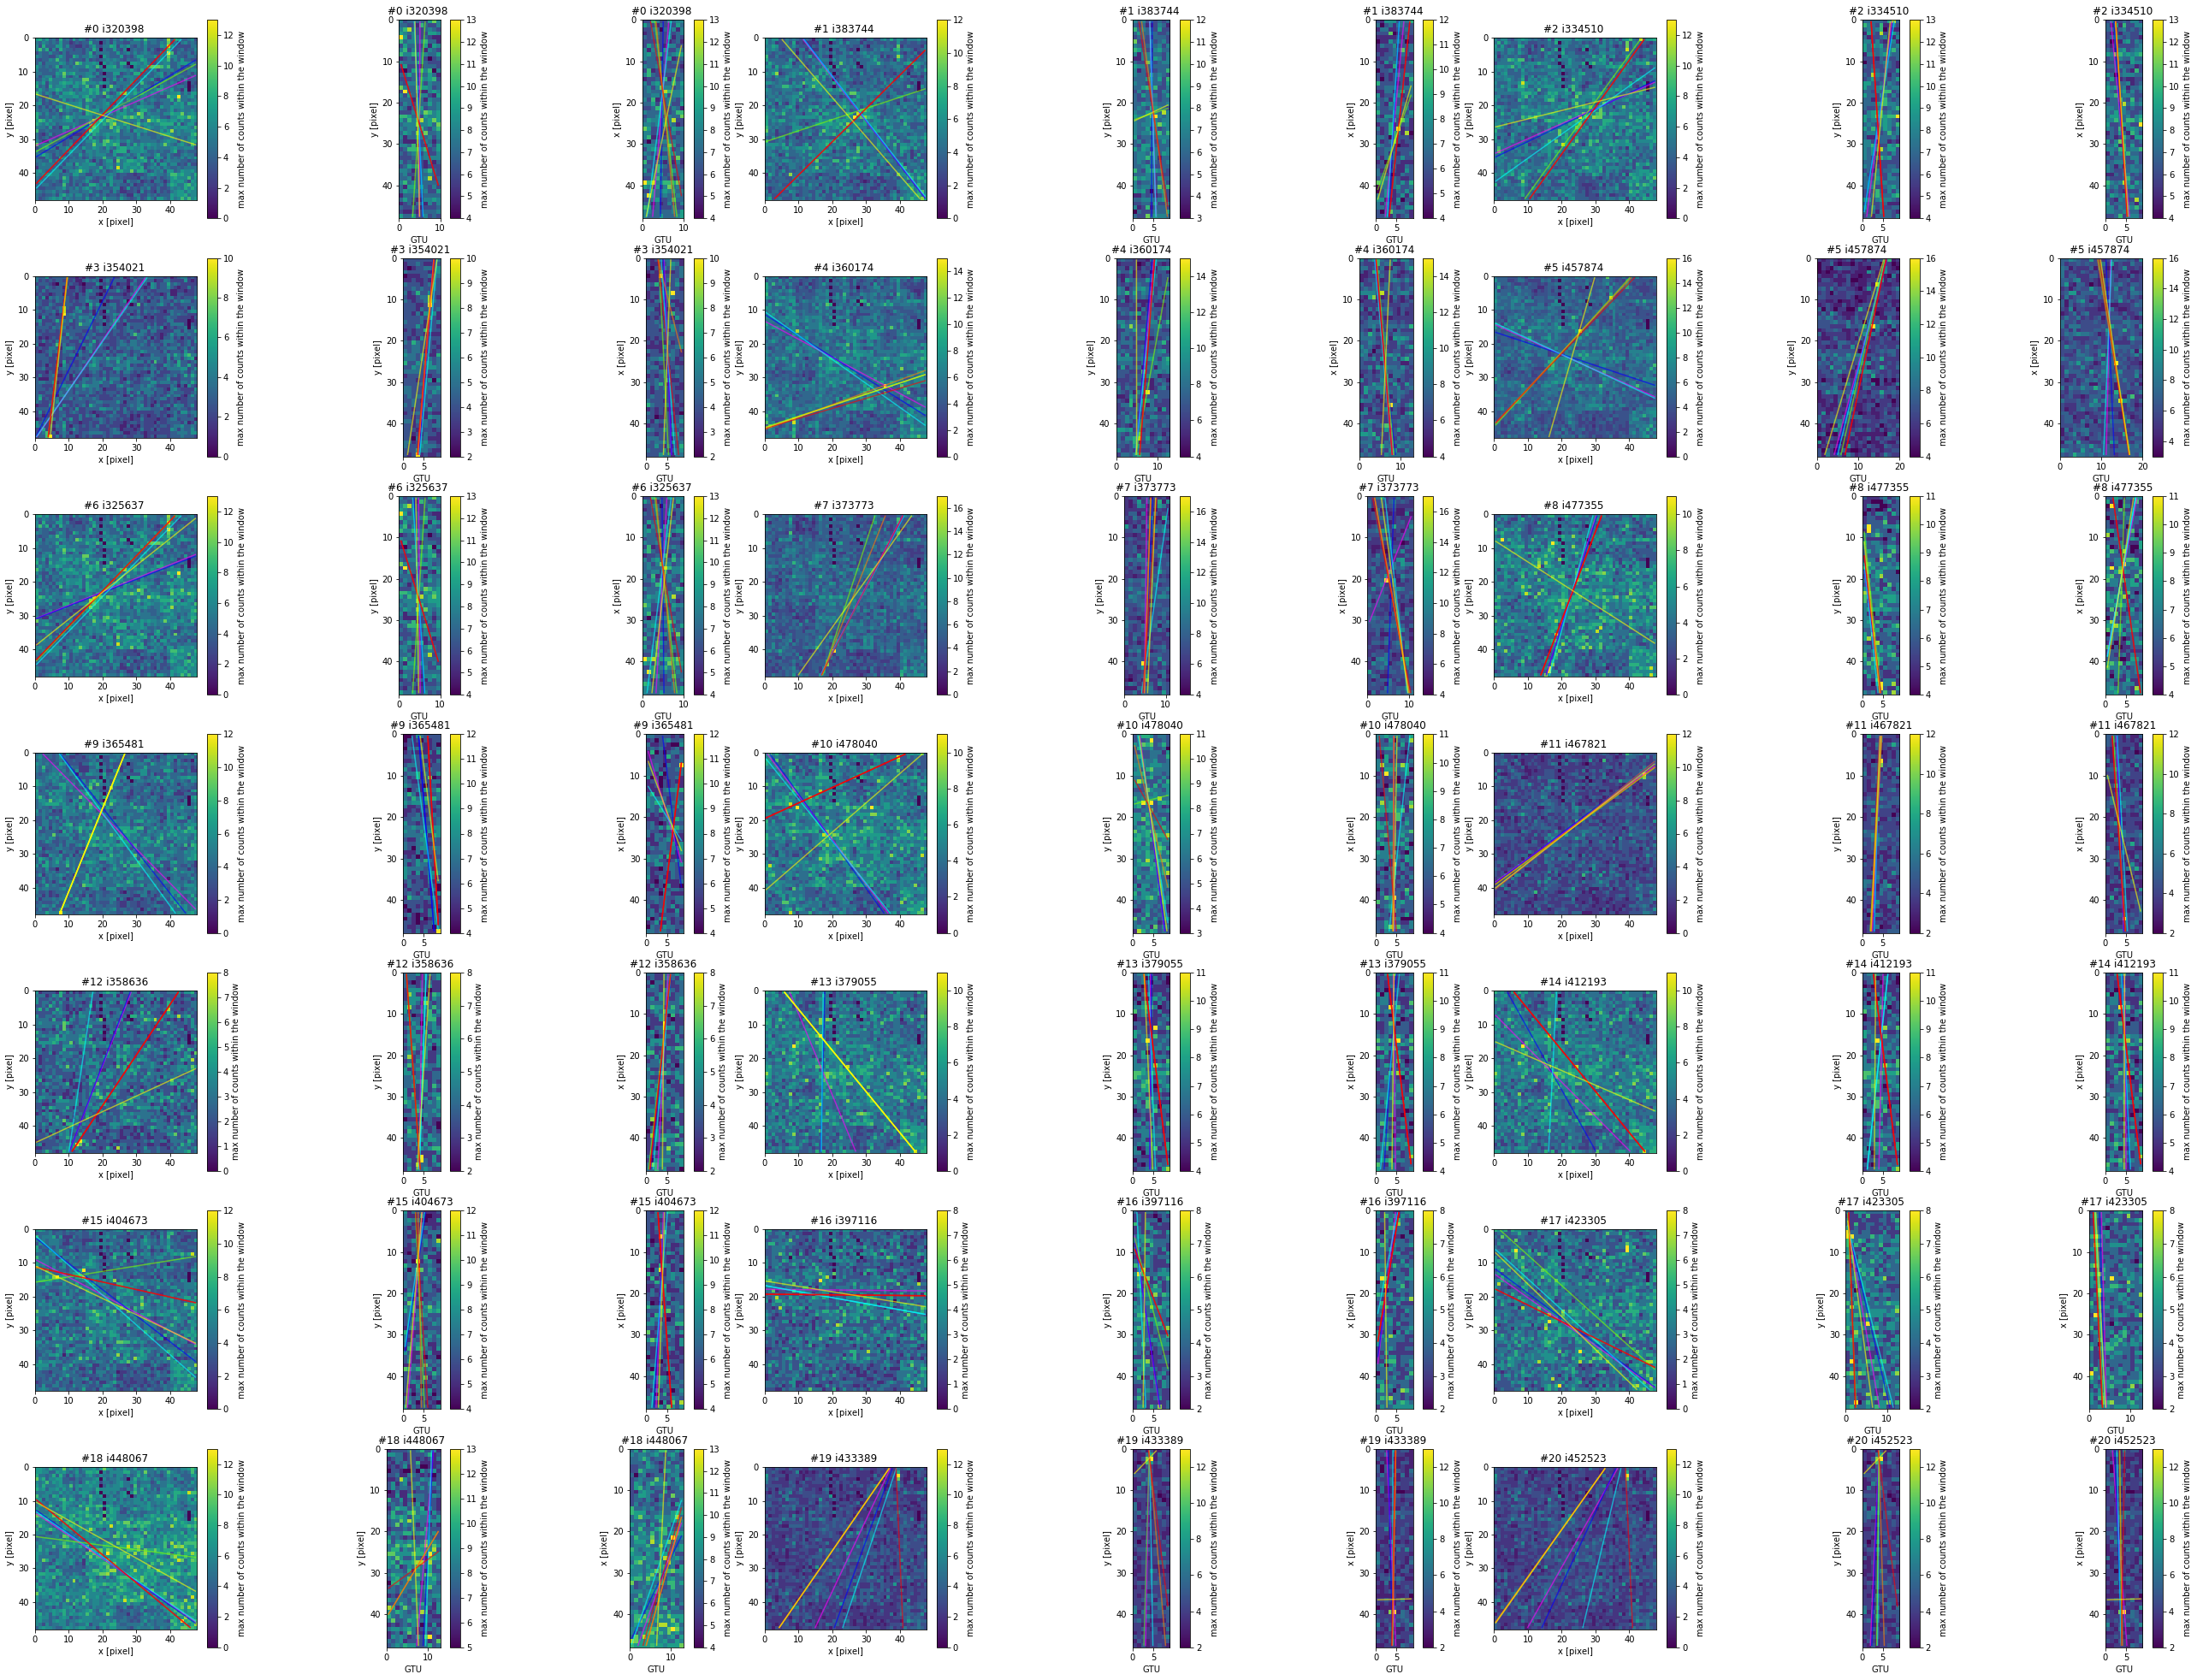

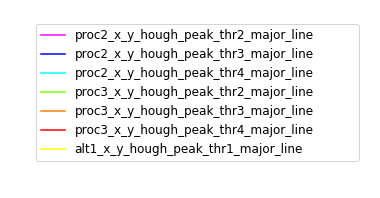

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc4950596d8>,
 <matplotlib.figure.Figure at 0x7fc49cf65a20>)

In [32]:
vis_events_line_colors = ['#FF00FF','#0000FF','#00FFFF','#80FF00','#FF8000','#FF0000','yellow']
vis_events_line_columns_x_y = [('proc2_x_y_hough_peak_thr2_major_line_rho','proc2_x_y_hough_peak_thr2_major_line_phi'),('proc2_x_y_hough_peak_thr3_major_line_rho','proc2_x_y_hough_peak_thr3_major_line_phi'),('proc2_x_y_hough_peak_thr4_major_line_rho','proc2_x_y_hough_peak_thr4_major_line_phi'),('proc3_x_y_hough_peak_thr2_major_line_rho','proc3_x_y_hough_peak_thr2_major_line_phi'),('proc3_x_y_hough_peak_thr3_major_line_rho','proc3_x_y_hough_peak_thr3_major_line_phi'),('proc3_x_y_hough_peak_thr4_major_line_rho','proc3_x_y_hough_peak_thr4_major_line_phi'),('alt1_x_y_hough_peak_thr1_major_line_rho','alt1_x_y_hough_peak_thr1_major_line_phi')] 
vis_events_line_columns_gtu_x = [('proc2_gtu_x_hough_peak_thr2_major_line_rho','proc2_gtu_x_hough_peak_thr2_major_line_phi'),('proc2_gtu_x_hough_peak_thr3_major_line_rho','proc2_gtu_x_hough_peak_thr3_major_line_phi'),('proc2_gtu_x_hough_peak_thr4_major_line_rho','proc2_gtu_x_hough_peak_thr4_major_line_phi'),('proc3_gtu_x_hough_peak_thr2_major_line_rho','proc3_gtu_x_hough_peak_thr2_major_line_phi'),('proc3_gtu_x_hough_peak_thr3_major_line_rho','proc3_gtu_x_hough_peak_thr3_major_line_phi'),('proc3_gtu_x_hough_peak_thr4_major_line_rho','proc3_gtu_x_hough_peak_thr4_major_line_phi'),('alt1_gtu_x_hough_peak_thr1_major_line_rho','alt1_gtu_x_hough_peak_thr1_major_line_phi')] 
vis_events_line_columns_gtu_y = [('proc2_gtu_y_hough_peak_thr2_major_line_rho','proc2_gtu_y_hough_peak_thr2_major_line_phi'),('proc2_gtu_y_hough_peak_thr3_major_line_rho','proc2_gtu_y_hough_peak_thr3_major_line_phi'),('proc2_gtu_y_hough_peak_thr4_major_line_rho','proc2_gtu_y_hough_peak_thr4_major_line_phi'),('proc3_gtu_y_hough_peak_thr2_major_line_rho','proc3_gtu_y_hough_peak_thr2_major_line_phi'),('proc3_gtu_y_hough_peak_thr3_major_line_rho','proc3_gtu_y_hough_peak_thr3_major_line_phi'),('proc3_gtu_y_hough_peak_thr4_major_line_rho','proc3_gtu_y_hough_peak_thr4_major_line_phi'),('alt1_gtu_y_hough_peak_thr1_major_line_rho','alt1_gtu_y_hough_peak_thr1_major_line_phi')] 
vis_events_line_names = [os.path.commonprefix([col_rho,col_phi])[:-1] for col_rho, col_phi in vis_events_line_columns_x_y]

vis_events_df(second_subset_events_df, events_per_figure=20, max_figures=1, vis_gtux=True, vis_gtuy=True, close_after_vis=False, show=True, 
              additional_printed_columns=['etruth_truetheta','proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'],
              line_columns_x_y=vis_events_line_columns_x_y, 
              line_columns_gtu_x=vis_events_line_columns_gtu_x, 
              line_columns_gtu_y=vis_events_line_columns_gtu_y,
             line_colors=vis_events_line_colors, line_alpha=0.6)

draw_lines_legend(vis_events_line_colors, vis_events_line_names)

# #FF00FF  proc2_x_y_hough_peak_thr2_major_line_phi
# #0000FF  proc2_x_y_hough_peak_thr3_major_line_phi
# #00FFFF  proc2_x_y_hough_peak_thr4_major_line_phi
# #80FF00  proc3_x_y_hough_peak_thr2_major_line_phi
# #FF8000  proc3_x_y_hough_peak_thr3_major_line_phi
# #FF0000  proc3_x_y_hough_peak_thr4_major_line_phi
# yellow   alt1_x_y_hough_peak_thr1_major_line_phi

/home/spbproc/SPBDATA_processed/spb_simu/posz_27000000.00/energy_2.24e+12/thousnd27E7.2017-07-24-20h21m30s/npyconv/ev_65_mc_1__signals_p128_a0_g30_f128_b20170430-072445-001.001_k1_s0_d32_n1_m128.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_27000000.00/energy_2.24e+12/thousnd27E7.2017-07-24-20h21m30s/simu2npy/ev_65_mc_1__signals.npy #0 i320398 (-2, 8)
len(event_frames)=28 n_event_frames_count=10 n_event_frames.shape=(10, 48, 48) n_event_frames_offset=2 event_frames_sec_len=8 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.26e+12/thousnd33E2.2017-07-25-12h37m43s/npyconv/ev_65_mc_1__signals_p128_a0_g30_f128_b20170429-080135-029.001_k1_s0_d32_n8_m128.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.26e+12/thousnd33E2.2017-07-25-12h37m43s/simu2npy/ev_65_mc_1__signals.npy #1 i383744 (0, 9)
len(event_frames)=24 n_event_frames_count=9 n_event_frames.shape=(9, 48, 48) n_event_frames_offset=0 event_frames_sec_len=9 event_frames_

/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_6.31e+12/thousnd24E16.2017-07-26-08h52m30s/npyconv/ev_12_mc_1__signals_p128_a0_g30_f128_b20170427-105115-001.001_k1_s0_d32_n4_m128.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_6.31e+12/thousnd24E16.2017-07-26-08h52m30s/simu2npy/ev_12_mc_1__signals.npy #17 i423305 (20, 33)
len(event_frames)=25 n_event_frames_count=13 n_event_frames.shape=(13, 48, 48) n_event_frames_offset=0 event_frames_sec_len=5 event_frames_offset=20
/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_8.91e+12/thousnd18E19.2017-07-28-20h49m32s/npyconv/ev_5_mc_1__signals_p128_a0_g30_f128_b20170502-134817-001.001_k1_s0_d32_n3_m128.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_8.91e+12/thousnd18E19.2017-07-28-20h49m32s/simu2npy/ev_5_mc_1__signals.npy #18 i448067 (-2, 11)
len(event_frames)=17 n_event_frames_count=13 n_event_frames.shape=(13, 48, 48) n_event_frames_offset=2 event_frames_sec_len=11 ev

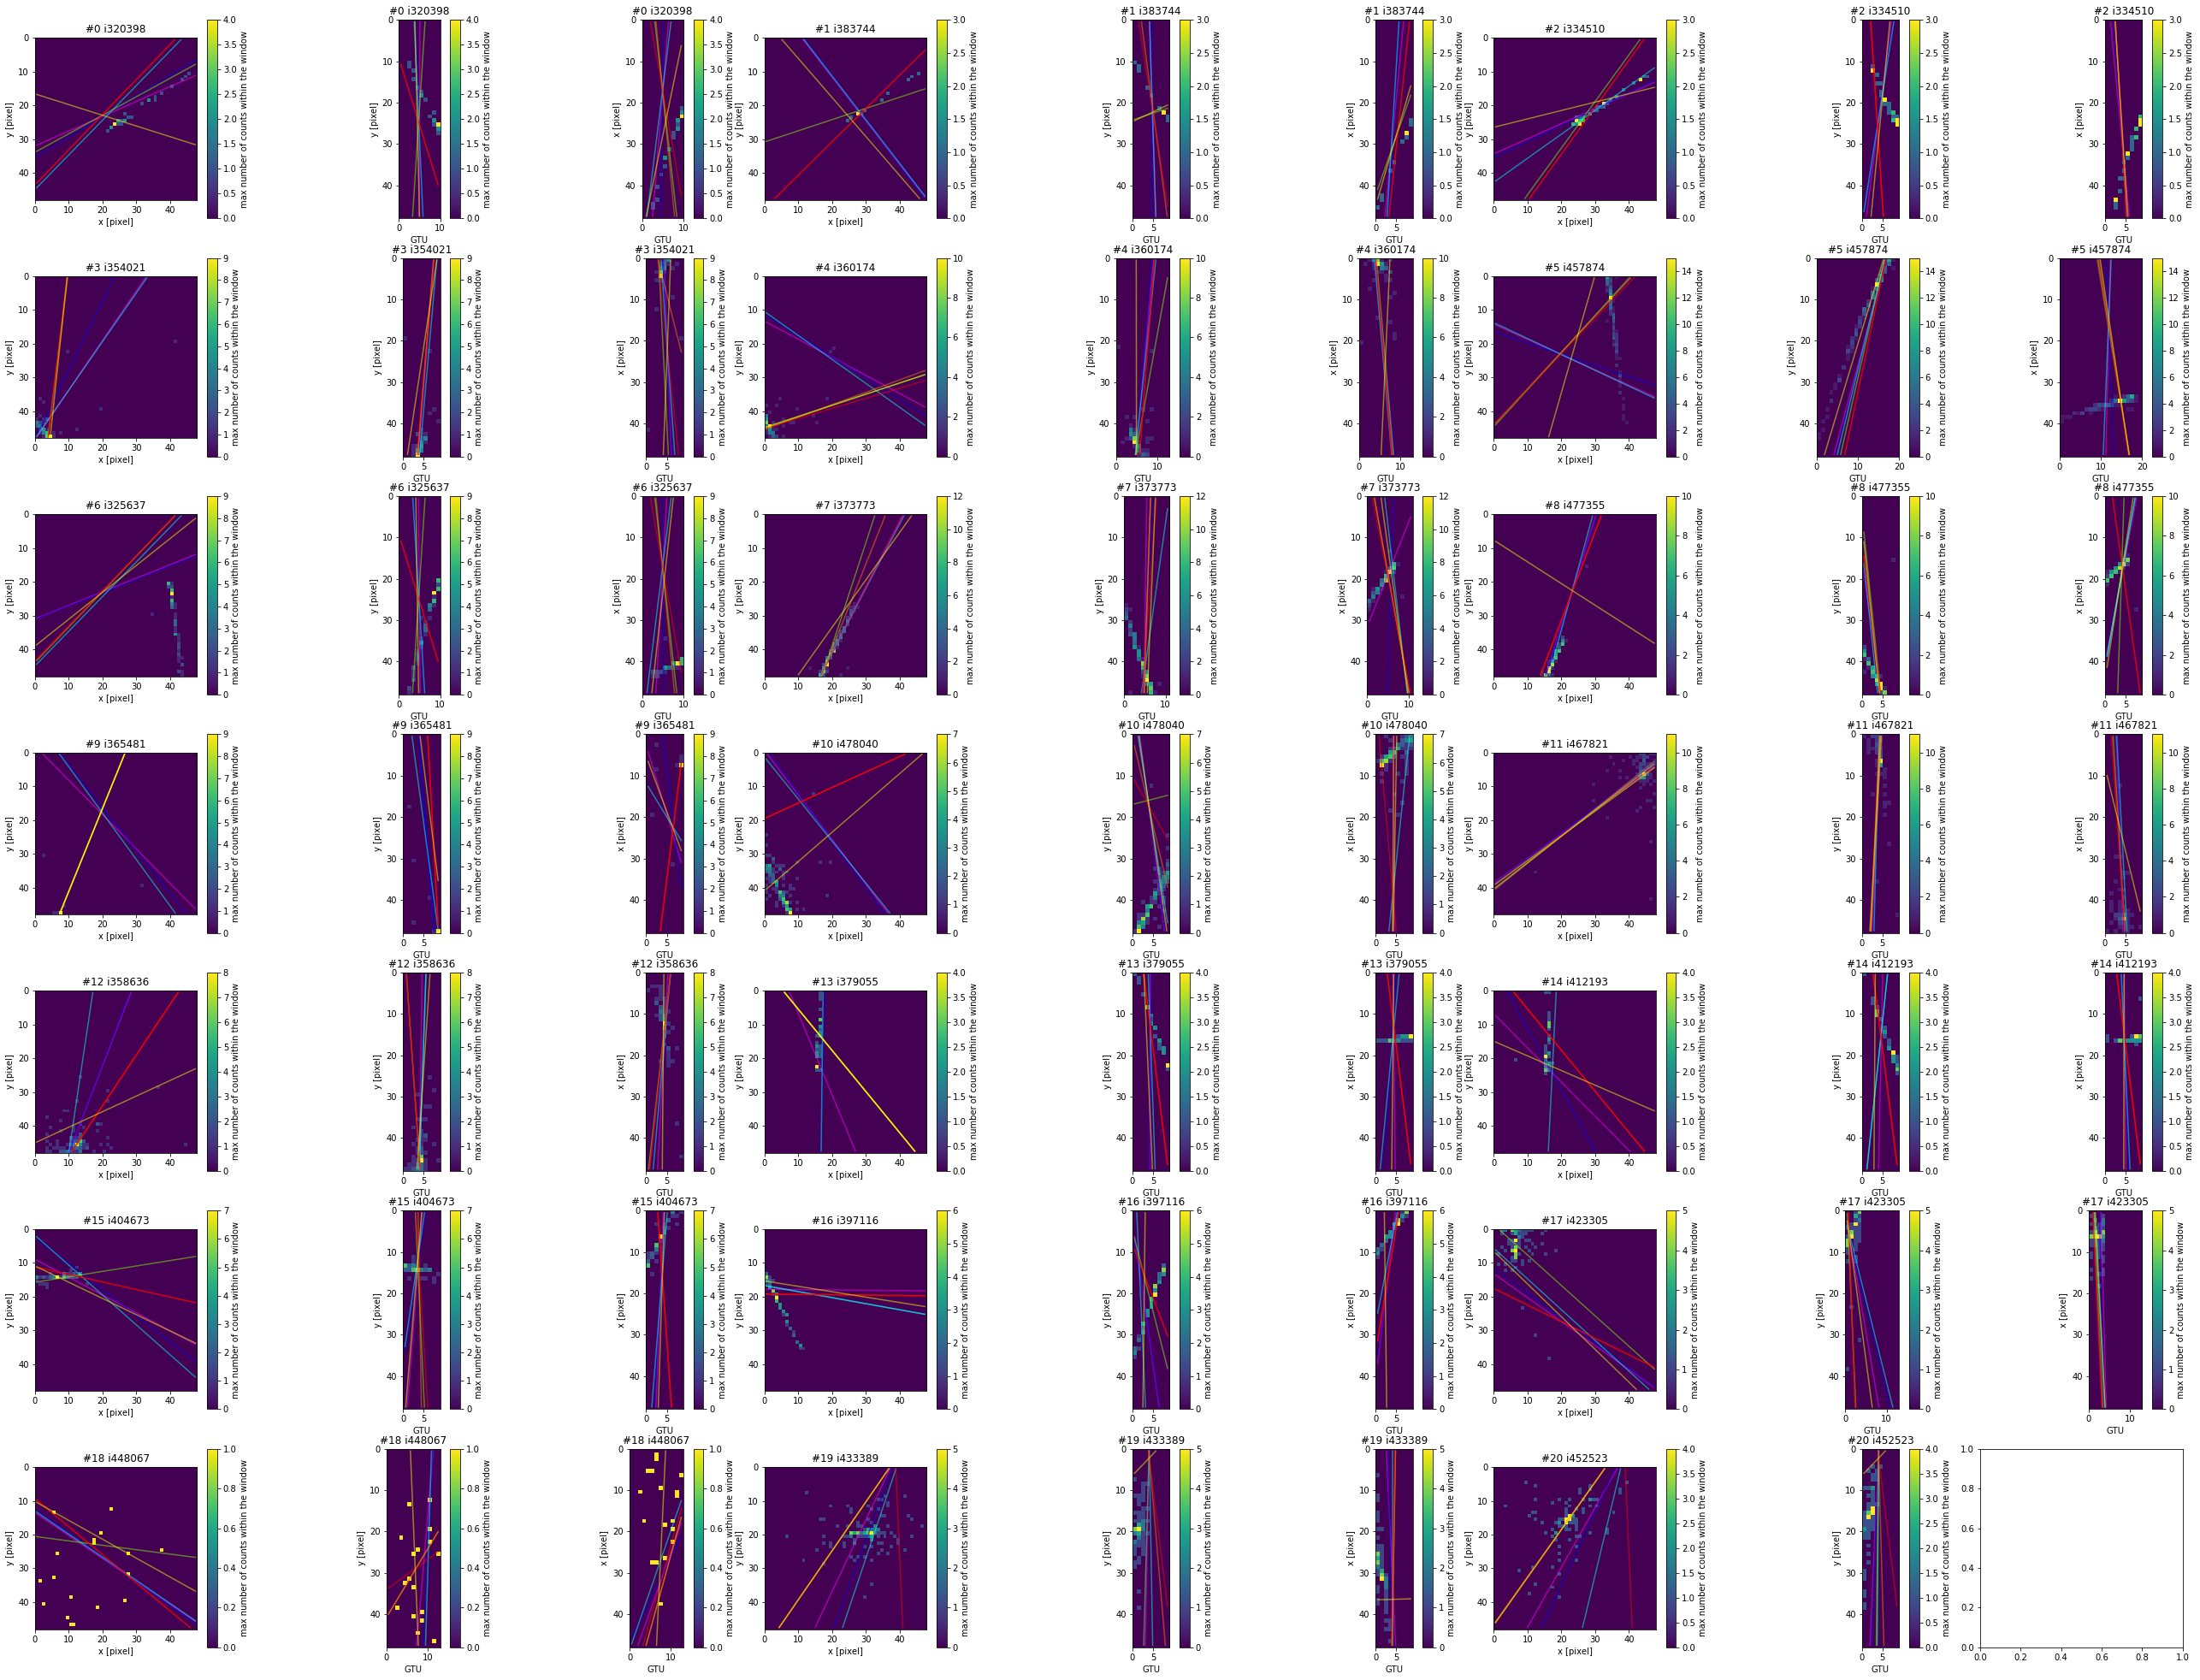

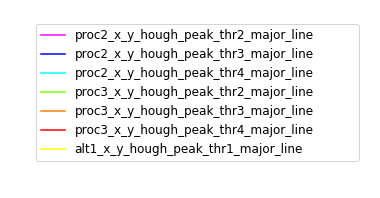

In [33]:
plt.close('all')

fig, axs = plt.subplots(7, 9)
fig.set_size_inches(9*5,7*5)
axs_flattened = axs.flatten()
ai = 0

# .iloc[4:5]
for i,(rid,r) in enumerate(second_subset_events_df.iterrows()):
    simu_gtu_start = r['gtu_in_packet']-4-30
    simu_gtu_end = simu_gtu_start+r['num_gtu']
    
    lines_xy = [(r[l[0]],r[l[1]]) for l in vis_events_line_columns_x_y]
    lines_gtux = [(r[l[0]],r[l[1]]) for l in vis_events_line_columns_gtu_x]
    lines_gtuy = [(r[l[0]],r[l[1]]) for l in vis_events_line_columns_gtu_y]
    
    if ai+2 >= len(axs_flattened):
        break
    
    print( r['source_file_acquisition_full'], acqnpy2simunpy(r['source_file_acquisition_full']), "#{} i{}".format(i, r['event_id']), (simu_gtu_start,simu_gtu_end) )
    visualize_simu_event_projections(r['source_file_acquisition_full'], title="#{} i{}".format(i, r['event_id']), axs_flattened=axs_flattened, 
                                    lines_xy=lines_xy, lines_gtux=lines_gtux, lines_gtuy=lines_gtuy, line_colors=vis_events_line_colors, line_alpha=.5, vis_xy=True, vis_gtux=True, vis_gtuy=True, ai=ai,
                                    gtu_range=(simu_gtu_start, simu_gtu_end) )
    ai += 3
    
    if ai >= len(axs_flattened):
        break

draw_lines_legend(vis_events_line_colors, vis_events_line_names)    
    
plt.show()

In [41]:
#events_selection_query_trg_1_selected = subset_events_df.set_index('source_file_acquisition',drop=False).join(events_selection_query_trg_1.set_index('source_file_acquisition'), how='left', rsuffix='_sel')
# events_selection_query_trg_1_selected = pd.merge(subset_events_df, events_selection_query_trg_1,
#                                         suffixes=['','_trg1'],
#                                         on='source_file_acquisition')

In [42]:
# print(len(events_selection_query_trg_1_selected))
# print(len(events_selection_query_trg_1_selected)/len(events_selection_query_trg_1))

In [43]:
# events_selection_query_trg_1_selected

In [44]:
# vis_events_line_colors = ['#FF00FF','#0000FF','#00FFFF','#80FF00','#FF8000','#FF0000','yellow']
# vis_events_line_columns_x_y = [('proc2_x_y_hough_peak_thr2_major_line_rho','proc2_x_y_hough_peak_thr2_major_line_phi'),('proc2_x_y_hough_peak_thr3_major_line_rho','proc2_x_y_hough_peak_thr3_major_line_phi'),('proc2_x_y_hough_peak_thr4_major_line_rho','proc2_x_y_hough_peak_thr4_major_line_phi'),('proc3_x_y_hough_peak_thr2_major_line_rho','proc3_x_y_hough_peak_thr2_major_line_phi'),('proc3_x_y_hough_peak_thr3_major_line_rho','proc3_x_y_hough_peak_thr3_major_line_phi'),('proc3_x_y_hough_peak_thr4_major_line_rho','proc3_x_y_hough_peak_thr4_major_line_phi'),('alt1_x_y_hough_peak_thr1_major_line_rho','alt1_x_y_hough_peak_thr1_major_line_phi')] 
# vis_events_line_columns_gtu_x = [('proc2_gtu_x_hough_peak_thr2_major_line_rho','proc2_gtu_x_hough_peak_thr2_major_line_phi'),('proc2_gtu_x_hough_peak_thr3_major_line_rho','proc2_gtu_x_hough_peak_thr3_major_line_phi'),('proc2_gtu_x_hough_peak_thr4_major_line_rho','proc2_gtu_x_hough_peak_thr4_major_line_phi'),('proc3_gtu_x_hough_peak_thr2_major_line_rho','proc3_gtu_x_hough_peak_thr2_major_line_phi'),('proc3_gtu_x_hough_peak_thr3_major_line_rho','proc3_gtu_x_hough_peak_thr3_major_line_phi'),('proc3_gtu_x_hough_peak_thr4_major_line_rho','proc3_gtu_x_hough_peak_thr4_major_line_phi'),('alt1_gtu_x_hough_peak_thr1_major_line_rho','alt1_gtu_x_hough_peak_thr1_major_line_phi')] 
# vis_events_line_columns_gtu_y = [('proc2_gtu_y_hough_peak_thr2_major_line_rho','proc2_gtu_y_hough_peak_thr2_major_line_phi'),('proc2_gtu_y_hough_peak_thr3_major_line_rho','proc2_gtu_y_hough_peak_thr3_major_line_phi'),('proc2_gtu_y_hough_peak_thr4_major_line_rho','proc2_gtu_y_hough_peak_thr4_major_line_phi'),('proc3_gtu_y_hough_peak_thr2_major_line_rho','proc3_gtu_y_hough_peak_thr2_major_line_phi'),('proc3_gtu_y_hough_peak_thr3_major_line_rho','proc3_gtu_y_hough_peak_thr3_major_line_phi'),('proc3_gtu_y_hough_peak_thr4_major_line_rho','proc3_gtu_y_hough_peak_thr4_major_line_phi'),('alt1_gtu_y_hough_peak_thr1_major_line_rho','alt1_gtu_y_hough_peak_thr1_major_line_phi')] 
# vis_events_line_names = [os.path.commonprefix([col_rho,col_phi])[:-1] for col_rho, col_phi in vis_events_line_columns_x_y]

# vis_events_df(events_selection_query_trg_1_selected, events_per_figure=20, max_figures=1, vis_gtux=True, vis_gtuy=True, close_after_vis=False, show=True, 
#               line_columns_x_y=vis_events_line_columns_x_y, 
#               line_columns_gtu_x=vis_events_line_columns_gtu_x, 
#               line_columns_gtu_y=vis_events_line_columns_gtu_y,
#              line_colors=vis_events_line_colors, line_alpha=0.0)

# draw_lines_legend(vis_events_line_colors, vis_events_line_names)